# Image Captioning with Flicker8k Dataset using TensorFlow/Keras

This notebook implements an image captioning model using the Flicker8k dataset. It utilizes a pre-trained InceptionV3 model for image feature extraction and an LSTM-based decoder to generate captions.

**Project Steps:**
1.  **Setup & Imports:** Install and import necessary libraries.
2.  **Data Loading:** Load image filenames and captions.
3.  **Caption Preprocessing:** Clean and tokenize captions.
4.  **Data Splitting:** Divide data into training and validation sets.
5.  **Image Feature Extraction:** Extract features using InceptionV3 and save them.
6.  **Model Building:** Define the Encoder-Decoder architecture.
7.  **Data Generator:** Create a generator for efficient training.
8.  **Training:** Train the captioning model.
9.  **Inference:** Generate captions for new images.

## 1. Setup & Imports

Install the required libraries. Uncomment the line below if you haven't installed them yet.

In [21]:
# !pip install tensorflow numpy pandas Pillow tqdm scikit-learn matplotlib

In [22]:
import os
import string
import numpy as np
import pandas as pd
from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tqdm.notebook import tqdm # Use notebook version for better display
tqdm().pandas()

0it [00:00, ?it/s]

## 2. Data Loading

Load the captions from `flicker8k/captions.txt` and define the paths for images and captions.

In [23]:
BASE_DIR = 'flicker8k'
CAPTIONS_PATH = os.path.join(BASE_DIR, 'captions.txt')
IMAGES_PATH = os.path.join(BASE_DIR, 'Images')

# Function to load captions
def load_captions(filename):
    """Loads captions from the file."""
    try:
        with open(filename, 'r') as file:
            lines = file.readlines()
    except FileNotFoundError:
        print(f"Error: Captions file not found at {filename}")
        return None
    
    mapping = {} # dictionary image -> list of captions
    for line in tqdm(lines[1:]): # Skip header row
        parts = line.strip().split(',', 1)
        if len(parts) == 2:
            image_id, caption = parts
            image_id = image_id.split('.')[0] # remove .jpg extension
            if image_id not in mapping:
                mapping[image_id] = []
            mapping[image_id].append(caption)
    return mapping

# Load captions
captions_mapping = load_captions(CAPTIONS_PATH)
if captions_mapping:
    print(f"\nLoaded captions for {len(captions_mapping)} images.")
    # Example
    # print(list(captions_mapping.keys())[0])
    # print(captions_mapping[list(captions_mapping.keys())[0]])

  0%|          | 0/40455 [00:00<?, ?it/s]


Loaded captions for 8091 images.


## 3. Caption Preprocessing

Clean the captions: lowercase, remove punctuation, remove single-character words, remove numeric tokens. Add `<start>` and `<end>` tokens. Create vocabulary and tokenizer.

In [24]:
def clean_captions(mapping):
    """Cleans captions in the mapping."""
    table = str.maketrans('', '', string.punctuation) # For removing punctuation
    for key, captions_list in tqdm(mapping.items()):
        for i in range(len(captions_list)):
            caption = captions_list[i]
            # Convert to lowercase
            caption = caption.lower()
            # Remove punctuation
            caption = caption.translate(table)
            # Remove words shorter than 2 chars and numeric tokens
            caption = ' '.join([word for word in caption.split() if len(word) > 1 and word.isalpha()])
            # Add start and end tokens
            captions_list[i] = '<start> ' + caption + ' <end>'

# Clean the loaded captions
if captions_mapping:
    clean_captions(captions_mapping)
    # Example of cleaned caption
    # print(captions_mapping[list(captions_mapping.keys())[0]])

# Create a flat list of all captions
all_captions = []
if captions_mapping:
    for key in captions_mapping:
        for caption in captions_mapping[key]:
            all_captions.append(caption)
print(f"Total captions: {len(all_captions)}")

  0%|          | 0/8091 [00:00<?, ?it/s]

Total captions: 40455


In [25]:
# Create Vocabulary
word_counts = Counter()
for caption in all_captions:
    word_counts.update(caption.split())

print(f"Total unique words initially: {len(word_counts)}")

# Filter vocabulary based on frequency (e.g., keep words appearing >= 5 times)
min_freq = 5
vocab = [word for word, count in word_counts.items() if count >= min_freq]
print(f"Vocabulary size after filtering (min_freq={min_freq}): {len(vocab)}")

# Create Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(vocab) # Fit only on the filtered vocabulary
vocab_size = len(tokenizer.word_index) + 1 # Add 1 for the padding token (index 0)
print(f"Final Vocabulary Size (including padding): {vocab_size}")

# Get word_to_index and index_to_word mappings
word_to_index = tokenizer.word_index
index_to_word = {index: word for word, index in word_to_index.items()}

# Find the maximum caption length
max_length = max(len(caption.split()) for caption in all_captions)
print(f"Maximum caption length: {max_length}")

# Save tokenizer and max_length
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
with open('max_length.pkl', 'wb') as f:
    pickle.dump(max_length, f)

Total unique words initially: 8765
Vocabulary size after filtering (min_freq=5): 2983
Final Vocabulary Size (including padding): 2982
Maximum caption length: 34


## 4. Data Splitting

Define training and validation image sets. We'll use a simple split: first 6000 images for training, next 1000 for validation (can be adjusted).

In [26]:
if captions_mapping:
    all_image_ids = list(captions_mapping.keys())
    np.random.shuffle(all_image_ids) # Shuffle for randomness
    
    num_train = 6000
    num_val = 1000 # Can also define a test set if needed
    
    train_image_ids = all_image_ids[:num_train]
    val_image_ids = all_image_ids[num_train : num_train + num_val]
    # test_image_ids = all_image_ids[num_train + num_val:]
    
    print(f"Training images: {len(train_image_ids)}")
    print(f"Validation images: {len(val_image_ids)}")
    # print(f"Test images: {len(test_image_ids)}")

    # Create train/val caption mappings
    train_captions = {img_id: captions_mapping[img_id] for img_id in train_image_ids}
    val_captions = {img_id: captions_mapping[img_id] for img_id in val_image_ids}
else:
    print("Caption mapping not loaded, cannot split data.")

Training images: 6000
Validation images: 1000


## 5. Image Feature Extraction

Use InceptionV3 pre-trained on ImageNet to extract features from the images. Save these features to avoid re-computation during training.

In [27]:
# Load InceptionV3 model, excluding the final classification layer
inception_model = InceptionV3(weights='imagenet')
# Create a new model, removing the last layer (classification layer)
feature_extractor = Model(inputs=inception_model.input, outputs=inception_model.layers[-2].output)
print("InceptionV3 Feature Extractor model loaded.")

# Function to preprocess an image for InceptionV3
def preprocess_image(image_path):
    try:
        img = load_img(image_path, target_size=(299, 299))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
        img_array = preprocess_input(img_array) # Preprocess for InceptionV3
        return img_array
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Function to extract features for a set of image IDs
def extract_features(image_ids, image_folder, model):
    features = {} 
    for img_id in tqdm(image_ids):
        image_file = img_id + '.jpg'
        image_path = os.path.join(image_folder, image_file)
        if os.path.exists(image_path):
            image = preprocess_image(image_path)
            if image is not None:
                feature = model.predict(image, verbose=0)
                features[img_id] = feature.flatten() # Flatten the feature vector
        else:
            print(f"Warning: Image file not found {image_path}")
    return features

# Define path for saving/loading features
FEATURES_FILE = 'image_features_inceptionv3.pkl'

# Check if features file exists, otherwise extract and save
if os.path.exists(FEATURES_FILE):
    print(f"Loading pre-computed features from {FEATURES_FILE}...")
    with open(FEATURES_FILE, 'rb') as f:
        all_features = pickle.load(f)
    print("Features loaded.")
else:
    print("Extracting features using InceptionV3...")
    if captions_mapping:
        all_image_ids_to_extract = list(captions_mapping.keys())
        all_features = extract_features(all_image_ids_to_extract, IMAGES_PATH, feature_extractor)
        print(f"Extracted features for {len(all_features)} images.")
        
        # Save features
        print(f"Saving features to {FEATURES_FILE}...")
        with open(FEATURES_FILE, 'wb') as f:
            pickle.dump(all_features, f)
        print("Features saved.")
    else:
        print("Caption mapping not loaded, cannot extract features.")
        all_features = {} # Initialize empty if extraction failed

# Filter features for train/val sets
train_features = {img_id: all_features[img_id] for img_id in train_image_ids if img_id in all_features}
val_features = {img_id: all_features[img_id] for img_id in val_image_ids if img_id in all_features}

print(f"Training features loaded: {len(train_features)}")
print(f"Validation features loaded: {len(val_features)}")

InceptionV3 Feature Extractor model loaded.
Loading pre-computed features from image_features_inceptionv3.pkl...
Features loaded.
Training features loaded: 6000
Validation features loaded: 1000


## 6. Model Building

Define the Encoder-Decoder model architecture. The encoder processes image features, and the decoder (LSTM) generates the caption sequence.

In [28]:
def define_captioning_model(vocab_size, max_length, feature_shape=2048, embedding_dim=256, rnn_units=512):
    # --- Encoder --- 
    # Feature extractor input (already extracted InceptionV3 features)
    inputs1 = Input(shape=(feature_shape,), name='image_features_input')
    # Add dropout and a dense layer to map features to the decoder's expected input dimension
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(rnn_units, activation='relu', name='feature_dense')(fe1) # Changed embedding_dim to rnn_units
    
    # --- Decoder --- 
    # Sequence input (the caption so far)
    inputs2 = Input(shape=(max_length,), name='caption_input')
    # Embedding layer
    se1 = Embedding(vocab_size, embedding_dim, mask_zero=True, name='caption_embedding')(inputs2)
    # Add dropout
    se2 = Dropout(0.5)(se1)
    # LSTM layer
    se3 = LSTM(rnn_units, name='lstm_decoder')(se2)
    
    # --- Combining Encoder & Decoder --- 
    decoder1 = add([fe2, se3])
    decoder2 = Dense(rnn_units, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # --- Create Model --- 
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.summary()
    return model

# Define the model
model = define_captioning_model(vocab_size, max_length, feature_shape=train_features[list(train_features.keys())[0]].shape[0])

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ caption_input       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_features_inp… │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ caption_embedding   │ (None, 34, 256)   │    763,392 │ caption_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 2048)      │          0 │ image_features_i… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 34, 256)   │          0 │ caption_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 34)        │          0 │ caption_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_dense       │ (None, 512)       │  1,049,088 │ dropout_4[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_decoder (LSTM) │ (None, 512)       │  1,574,912 │ dropout_5[0][0],  │
│                     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 512)       │          0 │ feature_dense[0]… │
│                     │                   │            │ lstm_decoder[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │    262,656 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 2982)      │  1,529,766 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,179,814 (19.76 MB)

 Trainable params: 5,179,814 (19.76 MB)

 Non-trainable params: 0 (0.00 B)

## 7. Data Generator

Create a custom Keras `Sequence` data generator to efficiently feed batches of data (image features, input sequences, output sequences) to the model during training. This is necessary because the entire dataset might not fit into memory.

In [29]:
class CaptionDataGenerator(Sequence):
    def __init__(self, image_ids, captions_mapping, features, tokenizer, max_length, vocab_size, batch_size):
        self.image_ids = image_ids
        self.captions_mapping = captions_mapping
        self.features = features
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        
        # Pre-process all samples when initialized for better performance
        self.all_samples = []
        for img_id in image_ids:
            if img_id in self.features:
                for caption in self.captions_mapping[img_id]:
                    self.all_samples.append((img_id, caption))
        
        # Shuffle the samples initially
        self.on_epoch_end()

    def __len__(self):
        # Return the number of batches (ceiling division ensures we use all samples)
        return int(np.ceil(len(self.all_samples) / self.batch_size))

    def __getitem__(self, index):
        # Get batch samples
        batch_samples = self.all_samples[index * self.batch_size : min((index + 1) * self.batch_size, len(self.all_samples))]
        
        # Initialize batch data
        X1 = np.zeros((len(batch_samples), self.features[batch_samples[0][0]].shape[0]))
        X2 = np.zeros((len(batch_samples), self.max_length))
        y = np.zeros((len(batch_samples), self.vocab_size))
        
        # Process each sample in batch
        for i, (img_id, caption) in enumerate(batch_samples):
            # Get image features
            feature = self.features[img_id]
            
            # Process caption
            seq = self.tokenizer.texts_to_sequences([caption])[0]
            
            # For simplicity, we'll use only one word prediction per caption in each batch
            # You can modify this to generate more training samples per caption if needed
            if len(seq) > 1:  # Make sure caption has at least 2 words (to have input and target)
                # Random position to split the sequence (for variety in training)
                split_point = np.random.randint(1, len(seq))
                in_seq = seq[:split_point]
                out_seq = seq[split_point]
                
                # Pad the input sequence
                in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                
                # One-hot encode the output word
                out_word = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                
                # Store in batch arrays
                X1[i] = feature
                X2[i] = in_seq
                y[i] = out_word
        
        # Return formatted correctly for TensorFlow
        # Change from list to tuple for inputs
        return (X1, X2), y

    def on_epoch_end(self):
        # Shuffle samples at the end of each epoch
        np.random.shuffle(self.all_samples)

batch_size = 64

if train_features and train_captions:
    train_generator = CaptionDataGenerator(train_image_ids, train_captions, train_features, tokenizer, max_length, vocab_size, batch_size)
    print("Training generator created.")
else:
    train_generator = None
    print("Could not create training generator due to missing data.")

if val_features and val_captions:
    val_generator = CaptionDataGenerator(val_image_ids, val_captions, val_features, tokenizer, max_length, vocab_size, batch_size)
    print("Validation generator created.")
else:
    val_generator = None
    print("Could not create validation generator due to missing data.")

Training generator created.
Validation generator created.


## 8. Training

Train the model using the data generator. Use callbacks to save the best model based on validation loss and potentially stop early if validation loss stops improving.

Checking for existing checkpoints...
Resuming training from checkpoint: best_model_epoch_16-val_loss_3.39.keras
Starting training from epoch 16
Starting training from epoch 16...
Epoch 17/20
Starting training from epoch 16
Starting training from epoch 16...
Epoch 17/20


d:\Ed\GL1\Deep-Learning\another-image-captioning\image_captioning_env\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
d:\Ed\GL1\Deep-Learning\another-image-captioning\image_captioning_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 3.4560
Epoch 17: val_loss improved from inf to 3.42236, saving model to best_model_epoch_17-val_loss_3.42.keras

Epoch 17: val_loss improved from inf to 3.42236, saving model to best_model_epoch_17-val_loss_3.42.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 164s 344ms/step - loss: 3.4561 - val_loss: 3.4224
Epoch 18/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 164s 344ms/step - loss: 3.4561 - val_loss: 3.4224
Epoch 18/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 3.4570
Epoch 18: val_loss did not improve from 3.42236
469/469 ━━━━━━━━━━━━━━━━━━━━ 160s 342ms/step - loss: 3.4571 - val_loss: 3.4495
Epoch 19/20

Epoch 18: val_loss did not improve from 3.42236
469/469 ━━━━━━━━━━━━━━━━━━━━ 160s 342ms/step - loss: 3.4571 - val_loss: 3.4495
Epoch 19/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 3.5017
Epoch 19: val_loss did not improve from 3.42236
469/469 ━━━━━━━━━━━━━━━━━━━━ 165s 352ms/step - loss: 3.5016 - val_loss: 3.5069
Epoch 20/20

Epoch 19: val_

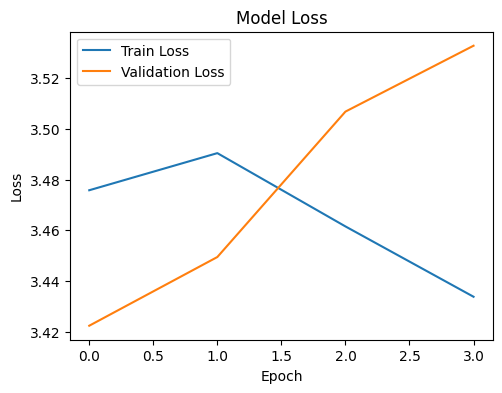

In [30]:
import glob # Import glob to find files
import re # Import re to parse epoch numbers

# Define callbacks
model_checkpoint_path_pattern = 'best_model_epoch_{epoch:02d}-val_loss_{val_loss:.2f}.keras'
checkpoint = ModelCheckpoint(model_checkpoint_path_pattern, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

early_stopping = EarlyStopping(monitor='val_loss', 
                             patience=5, 
                             verbose=1, 
                             mode='min',
                             restore_best_weights=True) # Keeps the best weights found

callbacks_list = [checkpoint, early_stopping]

epochs = 20
initial_epoch = 0
final_model_path = 'final_caption_model.weights.h5' # Changed extension
history = None # Initialize history to None

# Check if the final model already exists
if os.path.exists(final_model_path):
    print(f"Final model found at {final_model_path}. Loading weights and skipping training.")
    if model:
        model.load_weights(final_model_path)
    else:
        print("Model is not defined. Cannot load weights.")
elif train_generator and val_generator and model:
    print("Checking for existing checkpoints...")
    # Find existing checkpoint files
    checkpoint_files = glob.glob('best_model_epoch_*.keras')
    latest_checkpoint = None
    
    if checkpoint_files:
        # Find the checkpoint with the highest epoch number or latest modification time
        latest_checkpoint = max(checkpoint_files, key=os.path.getctime)
        print(f"Resuming training from checkpoint: {latest_checkpoint}")
        try:
            model.load_weights(latest_checkpoint)
            # Extract epoch number from filename to set initial_epoch
            match = re.search(r'epoch_(\d+)', latest_checkpoint)
            if match:
                initial_epoch = int(match.group(1)) # Start from the next epoch
                print(f"Starting training from epoch {initial_epoch}")
            else:
                 print("Could not parse epoch number from checkpoint filename. Starting from epoch 0.")
                 initial_epoch = 0
        except Exception as e:
            print(f"Error loading weights from {latest_checkpoint}: {e}. Starting training from scratch.")
            initial_epoch = 0
    else:
        print("No checkpoints found. Starting training from scratch.")
        initial_epoch = 0
        
    # Start or resume training only if the final model doesn't exist
    print(f"Starting training from epoch {initial_epoch}...")
    history = model.fit(
        train_generator,
        epochs=epochs,
        initial_epoch=initial_epoch, # Set the starting epoch
        validation_data=val_generator,
        callbacks=callbacks_list,
        verbose=1
    )
    print("Training finished.")
    
    # Save the final model weights after successful training
    print(f"Saving final model weights to {final_model_path}")
    model.save_weights(final_model_path)
    
    # Plot training history if training was performed
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
elif not model:
     print("Model is not defined. Cannot start training.")
elif not train_generator or not val_generator:
     print("Data generators not available. Cannot start training.")
else:
    print("Cannot start training. Check if model, generators, and data are loaded correctly.")

## 9. Inference

Create a function to generate captions for a new image using the trained model. This involves extracting features for the input image and then using the decoder part of the model iteratively to predict the caption word by word.

In [33]:
# Function to generate caption using greedy search
def generate_caption(image_path, model, feature_extractor, tokenizer, max_length, index_to_word):
    """Generates a caption for an image."""
    try:
        img_array = preprocess_image(image_path)
        if img_array is None:
            return "Error: Could not process image.", None
        
        feature = feature_extractor.predict(img_array, verbose=0)
        feature = feature.flatten()
        feature = np.expand_dims(feature, axis=0)

        in_text = '<start>'
        
        for i in range(max_length):
            sequence = tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], maxlen=max_length)
            
            yhat = model.predict([feature, sequence], verbose=0)
            
            last_word_idx = np.argmax(yhat)
            
            word = index_to_word.get(last_word_idx)
            
            if word is None:
                break
            in_text += ' ' + word
            if word == '<end>':
                break
                
        # Post-process the generated text
        final_caption_words = in_text.split()
        # Remove <start> and <end> tokens
        final_caption_words = [word for word in final_caption_words if word not in ['<start>', '<end>']]
        
        # Remove any trailing 'end' words that might have been predicted before the actual <end> token
        while final_caption_words and final_caption_words[-1] == 'end':
            final_caption_words.pop()
        
        final_caption = ' '.join(final_caption_words)
        
        img = Image.open(image_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        
        return final_caption, img

    except Exception as e:
        return f"Error during caption generation: {e}", None

## 10. Demonstration

Use the `generate_caption` function to generate a caption for an example image from the dataset.

Generating captions for validation images:

Processing image: 2949762776_52ece64d28


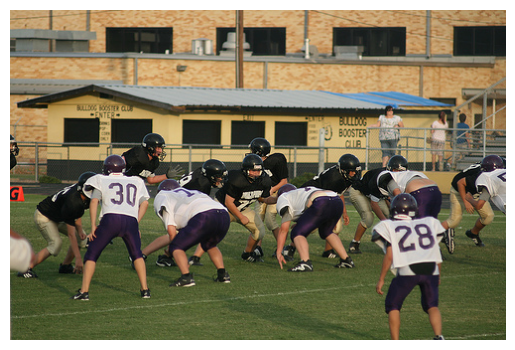

Generated Caption: group of men are playing soccer
Original Captions for 2949762776_52ece64d28:
  - football game is played
  - two football teams play game
  - two football teams playing game
  - two football teams play on the field
  - two teams of football players about to start game
------------------------------

Processing image: 2691966747_cfa154982b


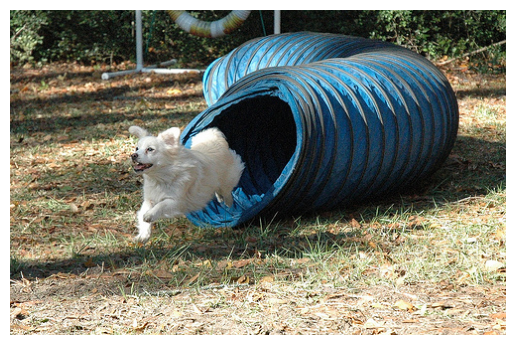

Generated Caption: two dogs are running through the grass end of the grass
Original Captions for 2691966747_cfa154982b:
  - white dog coming out of blue tunnel
  - white dog runs out of long blue tube outside
  - white dog runs through large blue tube
  - the small white dog is coming out of blue tunnel
  - the white dog emerges from the tunnel on the course
------------------------------

Processing image: 2355880294_8f78a6fea6


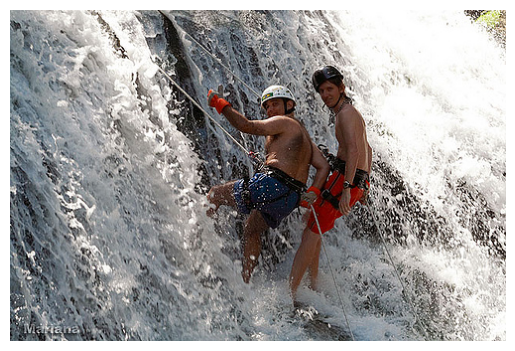

Generated Caption: man in blue shirt is jumping into the water
Original Captions for 2355880294_8f78a6fea6:
  - two athletic men climbing waterfall
  - two men are climbing rock face at waterfall
  - two men climb up waterfall using rope while wearing shorts and hard hats
  - two men hanging from ropes over waterfall
  - two men tethered by ropes climbing hill where water is flowing
------------------------------

Processing image: 3223224391_be50bf4f43


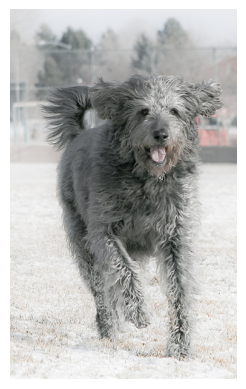

Generated Caption: two dogs are running through the grass end of the grass
Original Captions for 3223224391_be50bf4f43:
  - furry dog running on an open field of grass
  - gray fuzzy dog running through snow
  - gray terrier runs in snowcovered field
  - grey shaggy dog running
  - fluffy grey dog running in field
------------------------------

Processing image: 3523474077_16e14bc54c


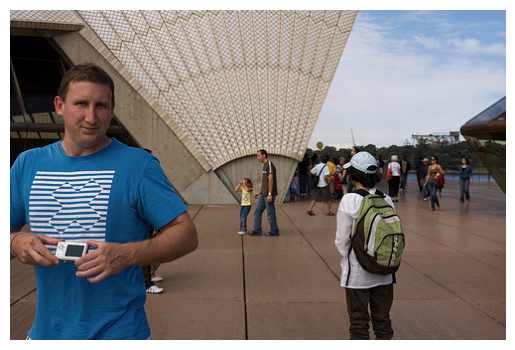

Generated Caption: two people are walking down the street end of the water
Original Captions for 3523474077_16e14bc54c:
  - man holding digital camera standing outside of huge building
  - man in blue shirt holding camera
  - man in blue tshirt holds camera
  - man wearing blue holds camera
  - the man in blue shirt is holding camera near to boy wearing backpack
------------------------------

Demonstration complete.


In [34]:
# Select a few validation image IDs (using val_image_ids instead of undefined test_ids)
test_image_ids = val_image_ids[:5] # Take first 5 validation images for demonstration

print("Generating captions for validation images:")

for img_id in test_image_ids:
    img_path = os.path.join(IMAGES_PATH, img_id + '.jpg')
    # No need to load features separately, generate_caption handles it
    # feature_path = os.path.join(FEATURES_DIR, img_id + '.pkl') # FEATURES_DIR is not defined

    # Check if image exists before generating caption
    if not os.path.exists(img_path):
        print(f"\nImage file not found: {img_path}. Skipping.")
        continue
        
    print(f"\nProcessing image: {img_id}")
    # Generate caption using the function
    generated_caption, img = generate_caption(img_path, model, feature_extractor, tokenizer, max_length, index_to_word)

    if img:
        # Display the image (already done in generate_caption)
        # plt.figure(figsize=(6, 6))
        # plt.imshow(img)
        # plt.title(f"Generated Caption:\n{generated_caption}", fontsize=10)
        # plt.axis('off')
        # plt.show()
        print(f"Generated Caption: {generated_caption}")
    else:
        print(f"Could not generate caption for {img_id}: {generated_caption}") # Print error message from generate_caption

    # Print original captions for comparison (optional)
    print(f"Original Captions for {img_id}:")
    # Use val_captions instead of undefined test_captions_dict
    if img_id in val_captions:
        for caption in val_captions[img_id]:
             # Remove start/end tokens for display
             clean_orig_caption = caption.replace('<start> ', '').replace(' <end>', '')
             print(f"  - {clean_orig_caption}")
    else:
        print("  Original captions not found for this image ID in the validation set.")
    print("-" * 30)

print("\nDemonstration complete.")